Medidas de informacion

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def read_grayscale_image(path):
    """Lee una imagen en escala de grises de la ruta especificada."""
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def calculate_ambe(original, processed):
    """Calcula el error de brillo medio absoluto (AMBE)."""
    return abs(np.mean(original) - np.mean(processed))

def calculate_psnr(original, processed):
    """Calcula la relación señal-ruido máxima (PSNR)."""
    return cv2.PSNR(original, processed)

def calculate_entropy(image):
    """Calcula la entropía de la imagen (medida de información)."""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()  # Convertir a probabilidades 1D
    return entropy(hist, base=2)  

def calculate_contrast(image):
    """Calcula el contraste como la desviación estándar de las intensidades de los píxeles."""
    return np.std(image)

Tecnicas de mejora de imagen

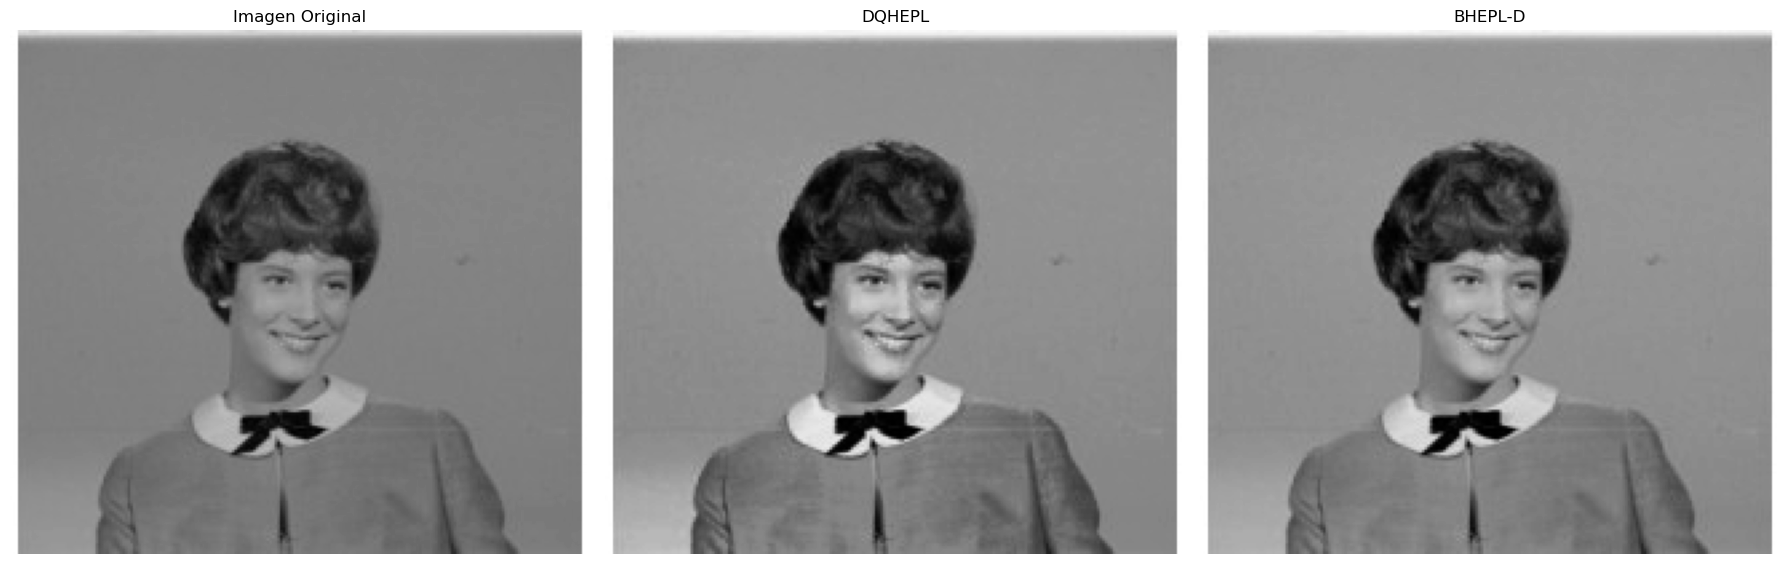

In [15]:
def apply_histogram_equalization(image):
    """Aplica ecualización de histograma para mejorar el contraste de la imagen."""
    return cv2.equalizeHist(image)

def apply_clahe(image, clip_limit, tile_grid_size):
    """Aplica CLAHE con el límite de clip y tamaño de la cuadrícula de mosaicos indicados."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)


def apply_dqhepl(image):
    """
    El método busca mejorar el contraste de imágenes preservando el brillo medio y evitando sobre-ecualización. Combina ideas de:
    1. División en cuadrantes dinámicos: Divide el histograma en 4 subhistogramas usando cuartiles estadísticos.
    2. Límites de meseta: Controla la amplificación del contraste recortando píxeles extremos.
    3. Preservación del brillo: Mantiene el punto medio del histograma original.
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    L = 256 
    """
    Cálculo del histograma y CDF
    
    CDF: Es la suma acumulada del histograma. Para cada nivel de intensidad k,
    el CDF en k es la suma de todas las frecuencias del histograma desde 0 hasta k.
    """
    hist = cv2.calcHist([image], [0], None, [L], [0, L]).flatten()
    total_pixels = image.shape[0] * image.shape[1]
    cdf = hist.cumsum()
    
    m0 = np.min(image)
    m4 = np.max(image)
    
    target_25 = 0.25 * total_pixels
    target_50 = 0.5 * total_pixels
    target_75 = 0.75 * total_pixels

    # Encontrar m1, m2, m3 usando la CDF
    m1 = np.argmax(cdf >= target_25)
    m2 = np.argmax(cdf >= target_50)
    m3 = np.argmax(cdf >= target_75)
    
    sub_ranges = []
    starts = [m0, m1 + 1, m2 + 1, m3 + 1]
    ends = [m1, m2, m3, m4]

    # Divide el histograma en 4 subhistogramas y a cada subhistograma le corresponde un rango de intensidades
    for start, end in zip(starts, ends):
        if start > end:
            start, end = end, start
        sub_ranges.append((start, end))
    
    clipped_hists = []
    Mis = []

    # Evitar amplificar ruido o zonas sobre-expuestas
    for start, end in sub_ranges:
        sub_hist = hist[start:end+1].copy()
        sum_sub = sub_hist.sum()
        num_levels = end - start
        if num_levels == 0:
            num_levels = 1
        Pi = sum_sub / num_levels # Límite de meseta
        clipped_sub_hist = np.minimum(sub_hist, Pi) # Recorte
        clipped_hists.append(clipped_sub_hist)
        Mis.append(clipped_sub_hist.sum()) # Total de píxeles recortados

    # Mapeo de Intensidades - Preservación del brillo
    n0 = 0
    n4 = L - 1
    
    denominator_n1 = m2 - m0
    if denominator_n1 != 0:
        n1 = m2 * (m1 - m0) / denominator_n1
    else:
        n1 = 0
    n1 = int(np.round(np.clip(n1, 0, 255)))
    
    n2 = int(np.clip(m2, 0, 255))
    
    denominator_n3 = m4 - m2
    if denominator_n3 != 0:
        n3 = ((L - 1 - m2) * (m3 - m2) / denominator_n3) + m2
    else:
        n3 = m2
    n3 = int(np.round(np.clip(n3, 0, 255)))
    
    new_ranges = [(n0, n1), (n1, n2), (n2, n3), (n3, n4)]
    
    lut = np.zeros(L, dtype=np.uint8)
    
    for i in range(4):
        start, end = sub_ranges[i]
        n_start, n_end = new_ranges[i]
        clipped_sub_hist = clipped_hists[i]
        Mi = Mis[i]
        
        if Mi == 0:
            lut[start:end+1] = n_start
            continue

        # Suma acumulada normalizada
        cum_clipped = clipped_sub_hist.cumsum()
        for idx in range(start, end + 1):
            if idx < 0 or idx >= L:
                continue
            pos = idx - start
            if pos < 0 or pos >= len(cum_clipped):
                continue
            cum_sum = cum_clipped[pos]
            Y = n_start + (n_end - n_start) * (cum_sum / Mi)
            Y = np.clip(Y, 0, 255)
            lut[idx] = int(np.round(Y))

    # Aplicar la Transformación
    enhanced_image = cv2.LUT(image, lut)
    return enhanced_image




def apply_bhepl_d(image):
    """
    Método de ecualización bi-histograma con límite de meseta basado en la mediana. Diseñado para:
    1. Mejorar contraste preservando brillo medio
    2. Evitar sobre-realce y saturación
    3. Mantener información de la imagen original
    """
    # Calcular histograma
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel().astype(np.float32)
    
    # Calcular brillo medio (m)
    total_pixels = image.size
    m = np.sum(np.arange(256) * (hist / total_pixels))
    m = int(round(m)) # Discretización del valor
    
    #  Segmentar histograma
    hL = hist[:m+1] # Sub-histograma inferior (0 a m)
    hU = hist[m+1:] if m < 255 else np.array([]) # Sub-histograma superior (m+1 a 255)
    
    # Calcular límites de meseta (medianas)
    PL = np.median(hL) if len(hL) > 0 else 0
    PU = np.median(hU) if len(hU) > 0 else 0
    
    # Recortar histogramas
    hCL = np.minimum(hL, PL)
    hCU = np.minimum(hU, PU) if m < 255 else np.array([])
    
    # Calcular masa total de los histogramas recortados
    MCL = np.sum(hCL)
    MCU = np.sum(hCU) if m < 255 else 0
    
    # Calcular funciones de mapeo
    map_L = np.zeros_like(hL, dtype=np.float32)
    if MCL > 0:
        # Para sub-histograma inferior
        cdf_L = np.cumsum(hCL)
        map_L = (m * (cdf_L / MCL)).astype(np.float32)
    
    map_U = np.zeros_like(hU, dtype=np.float32)
    if MCU > 0 and m < 255:
        # Para sub-histograma superior
        cdf_U = np.cumsum(hCU)
        map_U = ((m + 1) + (254 - m) * (cdf_U / MCU)).astype(np.float32)
    
    # Construir tabla de mapeo completa
    full_map = np.zeros(256, dtype=np.uint8)
    
    # Mapeo para el histograma inferior
    for k in range(len(map_L)):
        full_map[k] = np.clip(map_L[k], 0, 255)
    
    # Mapeo para el histograma superior
    for k in range(len(map_U)):
        full_map[m + 1 + k] = np.clip(map_U[k], 0, 255)
    
    # Aplicar la transformación
    enhanced_image = cv2.LUT(image, full_map)
    
    return enhanced_image
  
# Cargar imagen en escala de grises

img = read_grayscale_image("girl.jpeg")

# Aplicar DQHEPL
enhanced_image = apply_dqhepl(img)
enhanced_bhepl = apply_bhepl_d(img)

# Mostrar imágenes lado a lado
plt.figure(figsize=(18, 6))

# Imagen original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

# DQHEPL
plt.subplot(1, 3, 2)
plt.imshow(enhanced_image, cmap='gray')
plt.title('DQHEPL')
plt.axis('off')

# BHEPL-D
plt.subplot(1, 3, 3)
plt.imshow(enhanced_bhepl, cmap='gray')
plt.title('BHEPL-D')
plt.axis('off')

plt.tight_layout()
plt.show()